In [14]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer,  make_column_selector as selector
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import plot_confusion_matrix, recall_score,\
    accuracy_score, precision_score, f1_score

from sklearn.dummy import DummyClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

from sklearn.multioutput import MultiOutputClassifier

from sklearn.tree import DecisionTreeClassifier

import pickle

In [15]:
unpickleFile = open('./Data/clean_joined_df.pkl', 'rb')
df = pickle.load(unpickleFile, encoding='bytes')
df.head()

,DRIVERS_LICENSE_CLASS,SEX,AGE,SAFETY_EQUIPMENT,UNIT_TYPE,NUM_PASSENGERS,MAKE,MODEL,VEHICLE_DEFECT,VEHICLE_TYPE,...,ROAD_DEFECT,CRASH_TYPE,PRIM_CONTRIBUTORY_CAUSE,SEC_CONTRIBUTORY_CAUSE,STREET_DIRECTION,BEAT_OF_OCCURRENCE,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,INJURY_LEVEL
0,D,M,25.0,NONE PRESENT,DRIVER,0.0,HONDA,CIVIC,UNKNOWN,PASSENGER,...,NO DEFECTS,NO INJURY / DRIVE AWAY,UNABLE TO DETERMINE,NOT APPLICABLE,N,1531.0,3.0,7.0,9.0,0
1,NaN,M,37.0,SAFETY BELT USED,DRIVER,0.0,BUICK,ENCORE,NONE,PASSENGER,...,NO DEFECTS,NO INJURY / DRIVE AWAY,IMPROPER OVERTAKING/PASSING,FAILING TO REDUCE SPEED TO AVOID CRASH,W,613.0,22.0,2.0,4.0,0
2,NaN,X,NaN,USAGE UNKNOWN,DRIVER,0.0,UNKNOWN,UNKNOWN,NONE,PASSENGER,...,NO DEFECTS,NO INJURY / DRIVE AWAY,DRIVING SKILLS/KNOWLEDGE/EXPERIENCE,NOT APPLICABLE,W,821.0,5.0,1.0,11.0,0
3,NaN,X,NaN,USAGE UNKNOWN,DRIVER,0.0,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN/NA,...,NO DEFECTS,NO INJURY / DRIVE AWAY,UNABLE TO DETERMINE,UNABLE TO DETERMINE,N,2023.0,8.0,1.0,11.0,0
4,NaN,X,NaN,USAGE UNKNOWN,DRIVER,0.0,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN/NA,...,NO DEFECTS,NO INJURY / DRIVE AWAY,UNABLE TO DETERMINE,NOT APPLICABLE,S,223.0,10.0,1.0,11.0,0


In [16]:
# Drop rows with a cause that has less than 10k total
drop_list = []
for cause, number in zip(df.PRIM_CONTRIBUTORY_CAUSE.value_counts().index, df.PRIM_CONTRIBUTORY_CAUSE.value_counts()):
    if number < 10000:
        drop_list.append(cause)
df.PRIM_CONTRIBUTORY_CAUSE.value_counts()

UNABLE TO DETERMINE                                                                 380362
FAILING TO YIELD RIGHT-OF-WAY                                                       133013
FOLLOWING TOO CLOSELY                                                               132795
IMPROPER OVERTAKING/PASSING                                                          57294
FAILING TO REDUCE SPEED TO AVOID CRASH                                               51012
NOT APPLICABLE                                                                       49737
IMPROPER LANE USAGE                                                                  43608
IMPROPER BACKING                                                                     41129
IMPROPER TURNING/NO SIGNAL                                                           39791
DRIVING SKILLS/KNOWLEDGE/EXPERIENCE                                                  30957
DISREGARDING TRAFFIC SIGNALS                                                         25028

<AxesSubplot:>

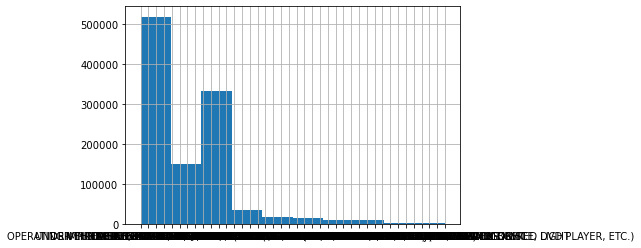

In [17]:
df.PRIM_CONTRIBUTORY_CAUSE.hist()

In [18]:
# We'll also drop 'unable to determine' as it isn't helpful here
# Same with not applicable 
drop_list.append('UNABLE TO DETERMINE')
drop_list.append('NOT APPLICABLE')
df = df[~df['PRIM_CONTRIBUTORY_CAUSE'].isin(drop_list)]
df.PRIM_CONTRIBUTORY_CAUSE.value_counts()

FAILING TO YIELD RIGHT-OF-WAY                                                       133013
FOLLOWING TOO CLOSELY                                                               132795
IMPROPER OVERTAKING/PASSING                                                          57294
FAILING TO REDUCE SPEED TO AVOID CRASH                                               51012
IMPROPER LANE USAGE                                                                  43608
IMPROPER BACKING                                                                     41129
IMPROPER TURNING/NO SIGNAL                                                           39791
DRIVING SKILLS/KNOWLEDGE/EXPERIENCE                                                  30957
DISREGARDING TRAFFIC SIGNALS                                                         25028
WEATHER                                                                              16357
DISREGARDING STOP SIGN                                                               14059

In [19]:
df.isna().sum()

DRIVERS_LICENSE_CLASS      173282
SEX                             0
AGE                        123982
SAFETY_EQUIPMENT                0
UNIT_TYPE                       0
NUM_PASSENGERS                  0
MAKE                            0
MODEL                           0
VEHICLE_DEFECT                  0
VEHICLE_TYPE                    0
VEHICLE_USE                     0
MANEUVER                        0
FIRST_CONTACT_POINT             0
POSTED_SPEED_LIMIT              0
WEATHER_CONDITION               0
LIGHTING_CONDITION              0
FIRST_CRASH_TYPE                0
TRAFFICWAY_TYPE                 0
ALIGNMENT                       0
ROADWAY_SURFACE_COND            0
ROAD_DEFECT                     0
CRASH_TYPE                      0
PRIM_CONTRIBUTORY_CAUSE         0
SEC_CONTRIBUTORY_CAUSE          0
STREET_DIRECTION                0
BEAT_OF_OCCURRENCE              0
CRASH_HOUR                      0
CRASH_DAY_OF_WEEK               0
CRASH_MONTH                     0
INJURY_LEVEL  

In [20]:
df.VEHICLE_TYPE.value_counts()

PASSENGER                                 393894
SPORT UTILITY VEHICLE (SUV)                85181
UNKNOWN/NA                                 32365
VAN/MINI-VAN                               30884
PICKUP                                     18902
TRUCK - SINGLE UNIT                        11709
BUS OVER 15 PASS.                           7186
OTHER                                       6074
TRACTOR W/ SEMI-TRAILER                     5638
MOTORCYCLE (OVER 150CC)                     1576
BUS UP TO 15 PASS.                          1425
TRACTOR W/O SEMI-TRAILER                     779
SINGLE UNIT TRUCK WITH TRAILER               704
OTHER VEHICLE WITH TRAILER                   674
MOTOR DRIVEN CYCLE                           163
MOPED OR MOTORIZED BICYCLE                   147
AUTOCYCLE                                    147
ALL-TERRAIN VEHICLE (ATV)                     68
FARM EQUIPMENT                                28
3-WHEELED MOTORCYCLE (2 REAR WHEELS)          20
RECREATIONAL OFF-HIG

In [21]:
df.VEHICLE_USE.value_counts()

PERSONAL                        435561
UNKNOWN/NA                       94513
OTHER                            18695
TAXI/FOR HIRE                    10184
COMMERCIAL - SINGLE UNIT          8124
RIDESHARE SERVICE                 6480
CTA                               4650
POLICE                            3585
CONSTRUCTION/MAINTENANCE          2888
COMMERCIAL - MULTI-UNIT           2632
NOT IN USE                        2313
OTHER TRANSIT                     2100
SCHOOL BUS                        1731
TOW TRUCK                         1206
AMBULANCE                          650
STATE OWNED                        517
DRIVER EDUCATION                   494
MASS TRANSIT                       442
FIRE                               421
LAWN CARE/LANDSCAPING              266
AGRICULTURE                         59
CAMPER/RV - SINGLE UNIT             30
MILITARY                            23
HOUSE TRAILER                       11
CAMPER/RV - TOWED/MULTI-UNIT         5
Name: VEHICLE_USE, dtype:

In [22]:
# have to cut down on variables as modeling is taking WAY too long, don't have time
df.drop(columns=['MAKE', 'MODEL', 'VEHICLE_DEFECT', 'SEC_CONTRIBUTORY_CAUSE', 'STREET_DIRECTION',
                'VEHICLE_USE', 'VEHICLE_TYPE'], inplace=True)

In [23]:
# Create train/test split
X = df.drop('PRIM_CONTRIBUTORY_CAUSE', axis=1)
y = df[['PRIM_CONTRIBUTORY_CAUSE']]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [24]:
# I know some columns are still not 100% clean(age having some negative numbers/0, speed having the same)
# but I'll need to come back to this after running the gridsearch

Next we'll create our pipelines, including the imbalanced pipeline.

In [25]:
# label encode target
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)

C:\Users\mitch\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [26]:
le.classes_

array(['DISREGARDING STOP SIGN', 'DISREGARDING TRAFFIC SIGNALS',
       'DRIVING SKILLS/KNOWLEDGE/EXPERIENCE',
       'FAILING TO REDUCE SPEED TO AVOID CRASH',
       'FAILING TO YIELD RIGHT-OF-WAY', 'FOLLOWING TOO CLOSELY',
       'IMPROPER BACKING', 'IMPROPER LANE USAGE',
       'IMPROPER OVERTAKING/PASSING', 'IMPROPER TURNING/NO SIGNAL',
       'OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELESS, NEGLIGENT OR AGGRESSIVE MANNER',
       'WEATHER'], dtype=object)

In [27]:
# Create pipes

subpipe_num = Pipeline(steps=[
    ('num_impute', SimpleImputer(strategy='median')),
    ('ss', StandardScaler()),
])


subpipe_cat = Pipeline(steps=[
    ('cat_impute',SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

CT = ColumnTransformer(transformers=[
    ('subpipe_num', subpipe_num, selector(dtype_include=np.number)),
    ('subpipe_cat', subpipe_cat, selector(dtype_include=object))], remainder='passthrough')

In [28]:
imb_dt_pipe = ImPipeline(steps=[
#     CT pipe will be run seperately, as it takes a long time
#     So that we're not running this part of the pipe repeatedly
#     ('ct',CT),
    ('sm',SMOTE(random_state=42)),
    ('dt', DecisionTreeClassifier(random_state=42))
])

In [29]:
parameters = {
    'dt__max_depth': [2],
    'sm__k_neighbors': [3,5,7],
    'sm__sampling_strategy': [0.8,0.6,0.4]
}


gs_dt = GridSearchCV(imb_dt_pipe, parameters, cv=10, verbose=2)

In [30]:
X_train.shape

(448185, 22)

In [31]:
# As is, this is taking much too long.
# Need to cut down on variables.

In [ ]:
X_train_transformed = CT.fit_transform(X_train)

In [ ]:
X_train_transformed

In [ ]:
gs_dt.fit(X_train_transformed, y_train_enc)

Fitting 10 folds for each of 9 candidates, totalling 90 fits
[CV] dt__max_depth=2, sm__k_neighbors=3, sm__sampling_strategy=0.8 ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


In [1]:
# I unfortunately wasn't able to create any viable gridsearches using the dataframe as is.
# Will create functions to engineer variables/clean manually
# This may lead to some slight data leakage but it appears to be the only way to proceed.